## creeren van een fan
obv de gegeven code een "fan" object maken

In [1]:
from concepts import Component, Assembly, Composite, SYSTEMType, InputStates, ELSE, ALWAYS, SYSTEM
from components import DrivingShaft, AirOutlet, Axle, InputPlug, DrivenShaft
from typing import Union

class Motor(Component):
    def __init__(self, parent, name:str):
        super().__init__(parent, name)
        self.signal = InputPlug(self, "power")
        self.shaft = DrivingShaft(self, "shaft")

        self.setNormal([([self.signal.present.YES] , [self.shaft.moving.YES]),
                        (ELSE                      , [self.shaft.moving.NO])])

        self.addFailure("broken", 0.005, [(ALWAYS, [self.shaft.moving.NO])])

class Blades(Component):
    def __init__(self, parent, name):
        super().__init__(parent, name)

        self.shaft = DrivenShaft(self, "shaft")
        self.air = AirOutlet(self, "air outlet")

        self.setNormal([([self.shaft.moving.YES] , [self.air.present.YES]),
                        (ELSE                    , [self.air.present.NO])])

        self.addFailure("broken", 0.002, [(ALWAYS, [self.air.present.NO])])

class Fan(Assembly):
    def __init__(self, parent, name):
        super().__init__(parent, name)
        
        self.motor = Motor(self, "Motor")
        self.blades = Blades(self, "Blades")

        self.c1 = self.addConnection(Axle(self.motor.shaft, self.blades.shaft))


# constructie
fan = Fan(SYSTEM, "Fan")


setting normal for Fan.Motor
setting normal for Fan.Blades
setting normal for axle connecting Motor.shaft ---> Blades.shaft


## deconstructie
om een mapping naar een diagram te maken moet de fan ook weer uit elkaar

In [2]:
import copy

# methoden in de TNO code voor deconstructie:
# getModules(), getAssemblies(), getComponents(),getCapabilities(), getConnectors(), getInputs(), getOutputs(), getConnections()

fancomponents = fan.getComponents()
for e in fancomponents:
    if isinstance(e, Motor): motor = copy.copy(e)
    if isinstance(e, Blades): blades = copy.copy(e)

fanconnections = fan.getConnections()
for c in fanconnections:
        axle = copy.copy(c)

inputs = motor.getInputs()
for i in inputs:
    if isinstance(i, InputPlug): 
        power = copy.copy(i)


# ook de failure situaties zijn opgenomen in de objecten
print("failures of Motor:")
flist = motor.failures
for f in flist:
    print(f.name)
    print(f.relation)
    print(f.prior)


failures of Motor:
broken
[([], [<Moving.NO: 2>])]
0.005


## Bayesgen.py
in de TNO software worden de volgende stappen gezet:


    # First generate all modules, then all connections. This ensures that the connection endpoints exist at connection creation time.
    generateModules(module, network, componentNodes, connectorNodes)
    generateConnections(module, network, componentNodes, connectorNodes, connectionNodes, cableTreeNodes)
    generateHealthLinks(module, network, componentNodes, connectorNodes, connectionNodes)

## influence diagram opbouwen: structuur
bij elke component verkregen uit de decompositie wordt een "health" node set toegevoegd

In [3]:
# imports
import os
import matplotlib.pyplot as plt
from pylab import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from IPython.display import display,HTML

In [4]:
# methode om bij gegeven component een standaard health, test, replace set toe te voegen
def addHealthTestReplaceToComponent(diagram, node):
    ids = []
    label = diagram.variable(node).description()
    H=diagram.addChanceNode(gum.LabelizedVariable('H' + label,'Health',["ok","broken"])) 
    T=diagram.addChanceNode(gum.LabelizedVariable('T'+label, 'Testoutcome', ["notdone", "positive", "negative"])) 
    DR=diagram.addDecisionNode(gum.LabelizedVariable('DR'+label, 'Replace', ["yes", "no"]))
    DT=diagram.addDecisionNode(gum.LabelizedVariable('DT'+label,'Test',["yes","no"])) 
    UR=diagram.addUtilityNode(gum.LabelizedVariable('UR'+label, 'Ureplace', ["U\(H, DR\)"]))
    UT=diagram.addUtilityNode(gum.LabelizedVariable('UT'+label, 'Utest', ["U\(DT\)"]))

    diagram.addArc(H, node)
    diagram.addArc(H, T)
    diagram.addArc(H, UR)
    diagram.addArc(DT, T)
    diagram.addArc(DT, UT)
    diagram.addArc(T, DR)
    diagram.addArc(DR, UR)
    ids = [H, T, DR, DT, UR, UT] 
    return ids


Influence Diagram{
  chance: 6,
  utility: 4,
  decision: 4,
  arcs: 15,
  domainSize: 2304
}


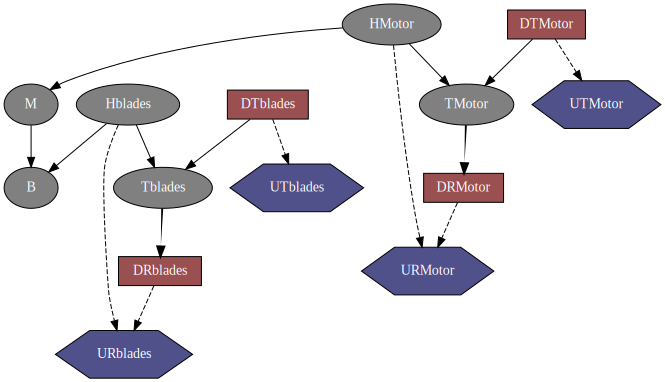

In [5]:
# creer influence diagram
diag = gum.InfluenceDiagram()

# loop door deconstructie en maak van elke component een node
M=diag.addChanceNode(gum.LabelizedVariable('M','Motor',["ok","broken"])) 
B=diag.addChanceNode(gum.LabelizedVariable('B','blades',["ok","broken"])) 
diag.addArc(M, B)

# toevoegen node set voor health, testen en vervangen
m_ids = addHealthTestReplaceToComponent(diag, M)
b_ids = addHealthTestReplaceToComponent(diag, B)

print(diag)
gnb.showInfluenceDiagram(diag, size=60)

## influence diagram opbouwen: cpt toevoegen

voor decisions zijn de toestanden genoeg
- decision test [yes / no] 
- decision replace (chance test) [yes / no]

cpt toevoegen voor volgende nodes
- chance node health [OK / broken] 
- chance node test (decision test / change health) [not done / positive / negative]

voor utility zie verderop

volgorde van de nodes in de output "m_ids": H, T, DR, DT, UR, UT


In [6]:
# cpt van motor: ok of broken afhankelijk van health motor
diag.cpt(M)[0] = [0.8, 0.2]
diag.cpt(M)[1] = [0.7, 0.3]

# health node health Motor, kans dat motor broken is klein
diag.cpt(m_ids[0]).fillWith([0.98,0.02]) 

# test node 
diag.cpt(m_ids[1])[0,0] = [0.1, 0.8, 0.1] # wel besluit te testen maar health ok dan grootste kans positieve test
diag.cpt(m_ids[1])[0,1] = [0.1, 0.1, 0.8] # wel besluit te testen maar health brokeen dan grootste kans negatieve test
diag.cpt(m_ids[1])[1,0] = [0.7, 0.2, 0.1] # besluit niet testen, health ok dan grootste kans bij notdone
diag.cpt(m_ids[1])[1,1] = [0.7, 0.1, 0.2] # besluit niet testen, health niet ok dan grootste kan bij notdone

gnb.flow.row( diag.cpt(m_ids[0]),diag.cpt(M), diag.cpt(m_ids[1]))

In [7]:
# cpt van motor: ok of broken afhankelijk van health motor
diag.cpt(B)[0] = [[0.9, 0.1], [0.8, 0.2]]
diag.cpt(B)[1] = [[0.8, 0.2], [0.7,0.3]]

# health node health Motor, kans dat motor broken is klein
diag.cpt(b_ids[0]).fillWith([0.98,0.02]) 

# test node 
diag.cpt(b_ids[1])[0,0] = [0.1, 0.8, 0.1] # wel besluit te testen maar health ok dan grootste kans positieve test
diag.cpt(b_ids[1])[0,1] = [0.1, 0.1, 0.8] # wel besluit te testen maar health brokeen dan grootste kans negatieve test
diag.cpt(b_ids[1])[1,0] = [0.7, 0.2, 0.1] # besluit niet testen, health ok dan grootste kans bij notdone
diag.cpt(b_ids[1])[1,1] = [0.7, 0.1, 0.2] # besluit niet testen, health niet ok dan grootste kan bij notdone

gnb.flow.row( diag.cpt(b_ids[0]),diag.cpt(B), diag.cpt(b_ids[1]))

## influence diagram opbouwen: utility functies

de utility functies werken obv kostencomponenten:
- c1 = kosten van een test = 10
- c2 = vervangingskosten = 20
- c3 = incorrect replacement penalty = 20
- c4 = failure to repair cost c4 >> c2 + c3 = 50

er is een treshold voor het vervangen van componenten ongeacht testen:
- treshold = P(H = 0) - (c2 + c3) / P (H = 1) c2 - c4 = 1
- P(H = 0) component in good condition
- P(H = 1) component in defect state
- voor duurdere onderdelen moet P(H = 1) hoger zijn voordat tot actie wordt overgegaan

utility functie voor correctief onderhoud:
- indien H = 0 / D = 0 (gezond en geen vervanging) dan kosten: nul
- indien H = 0 / D = 1 (gezond en wel vervangen) dan kosten: c2 + c3 (vervangingskosten en penalty)
- indien H = 1 / D = 0 (niet gezond, niet vervangen) dan kosten: c4 (failure to repair cost (groter dan c2 + c3)
- indien H = 1 / D = 1 (niet gezond, wel vervangen) dan kosten: c2 (vervangingskosten)

utility functie testen gezondheid:
- T = yes (wel testen): c1 (kosten test)
- T = no (niet testen): 0 (geen kosten)


In [8]:
# m_ids[5] = UT, m_ids[3] = DT
diag.utility(m_ids[5])[{'DTMotor':'no'}]=0 
diag.utility(m_ids[5])[{'DTMotor':'yes'}]=-10


In [9]:
diag.utility(m_ids[4])[{'HMotor':'ok','DRMotor':'yes'}]=40 # health=ok, replace=yes
diag.utility(m_ids[4])[{'HMotor':'broken','DRMotor':'yes' }]=20 # health=broken, replace=yes
diag.utility(m_ids[4])[{'HMotor':'ok','DRMotor':'no' }]=0 # health=ok, replace=no
diag.utility(m_ids[4])[{'HMotor':'broken','DRMotor':'no' }]=-50 # health=broken, replace=no

In [10]:
gnb.flow.row(diag.utility(m_ids[5]), diag.utility(m_ids[4]))

In [11]:
# m_ids[5] = UT, m_ids[3] = DT
diag.utility(b_ids[5])[{'DTBlades':'no'}]=0 
diag.utility(b_ids[5])[{'DTBlades':'yes'}]=-10

In [12]:
diag.utility(b_ids[4])[{'HBlades':'ok','DRBlades':'yes'}]=140 # health=ok, replace=yes
diag.utility(b_ids[4])[{'HBlades':'broken','DRBlades':'yes' }]=20 # health=broken, replace=yes
diag.utility(b_ids[4])[{'HBlades':'ok','DRBlades':'no' }]=0 # health=ok, replace=no
diag.utility(b_ids[4])[{'HBlades':'broken','DRBlades':'no' }]=-150 # health=broken, replace=no

In [13]:
ie = gum.ShaferShenoyLIMIDInference(diag) 
ie.makeInference()


In [14]:
gnb.flow.row(ie.optimalDecision(m_ids[3]), ie.optimalDecision(m_ids[2]))
gnb.flow.row(ie.optimalDecision(b_ids[3]), ie.optimalDecision(b_ids[2]))

In [15]:
ie.MEU() # maximum expected utility


{'mean': -120.4, 'variance': 7.839999999999887}

In [16]:
ie.posteriorUtility(m_ids[0])

(pyAgrum.Potential<double>@0x3c134fc8) 
  HMotor           |
ok       |broken   |
---------|---------|
 -120.0000| -140.0000|

In [17]:
gnb.flow.add(gnb.getInference(diag, size=60))
gnb.flow.display()

In [ ]:
diag.saveBIFXML("fan3.xml")